In [42]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols



### 1. Código para Acceder a la API y Obtener Datos

In [15]:
# URL base de la API
url = "https://datos.comunidad.madrid/catalogo/api/3/action/datastore_search"

#Parámetros de la solicitud
params = {
    "resource_id": "8423a948-3082-465e-b3f8-c13333e8969b",
    "limit": 10000  #limite deseado(se puede cambiar)
}

# Request de la solicitud
response = requests.get(url, params=params)

# Verificar si la solicitud fue exitosa
if response.status_code == 200:
    data = response.json()
    # Convertir los resultados a un DataFrame de pandas
    records = data['result']['records']
    df = pd.DataFrame(records)
    print(df.head())
else:
    print(f"Error {response.status_code}: {response.text}")

# Guardar los datos en un archivo CSV para su posterior análisis
csv_path = "sugerencias_quejas_agradecimientos.csv"
df.to_csv(csv_path, index=False)



   _id        tipo                         estado canal_entrada  \
0    1  Sugerencia        Contestada al Ciudadano      INTERNET   
1    2       Queja        Contestada al Ciudadano      INTERNET   
2    3       Queja        Contestada al Ciudadano      INTERNET   
3    4       Queja  Enviada a Otra Administración      INTERNET   
4    5       Queja        Contestada al Ciudadano      INTERNET   

         fecha_entrada   fecha_contestacion  \
0  2024-01-01T00:00:00  2024-01-26T00:00:00   
1  2024-01-01T00:00:00  2024-02-02T00:00:00   
2  2024-01-01T00:00:00  2024-05-14T00:00:00   
3  2024-01-02T00:00:00                 None   
4  2024-01-02T00:00:00  2024-01-17T00:00:00   

                                          consejeria  \
0           Consejería de Cultura, Turismo y Deporte   
1  Consejería de Vivienda, Transportes e Infraest...   
2  Consejería de Medio Ambiente, Agricultura e In...   
3          Consejería de Economía, Hacienda y Empleo   
4  Consejería de Educación, Univer

### 2. Exploración y Preprocesamiento de Datos


In [16]:
# Cargar los datos desde el archivo CSV
df = pd.read_csv(csv_path)
# Verificar los nombres de las columnas
#print(df.columns)

# Preprocesamiento
df.dropna(inplace=True)  # Eliminar valores faltantes
df.drop_duplicates(inplace=True)  # Eliminar duplicados

# Convertir las columnas de fecha a datetime
df['fecha_entrada'] = pd.to_datetime(df['fecha_entrada'], errors='coerce')
df['fecha_contestacion'] = pd.to_datetime(df['fecha_contestacion'], errors='coerce')
# Eliminar filas donde las fechas no se pudieron convertir
df.dropna(subset=['fecha_entrada', 'fecha_contestacion'], inplace=True)

print(df.columns)

Index(['_id', 'tipo', 'estado', 'canal_entrada', 'fecha_entrada',
       'fecha_contestacion', 'consejeria', 'unidad_descripcion', 'tema',
       'subtema'],
      dtype='object')


### 3. Análisis Exploratorio de Datos (EDA)


C:\Users\wilfr\AppData\Local\Temp\ipykernel_2428\3919837611.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='tipo', palette="viridis")


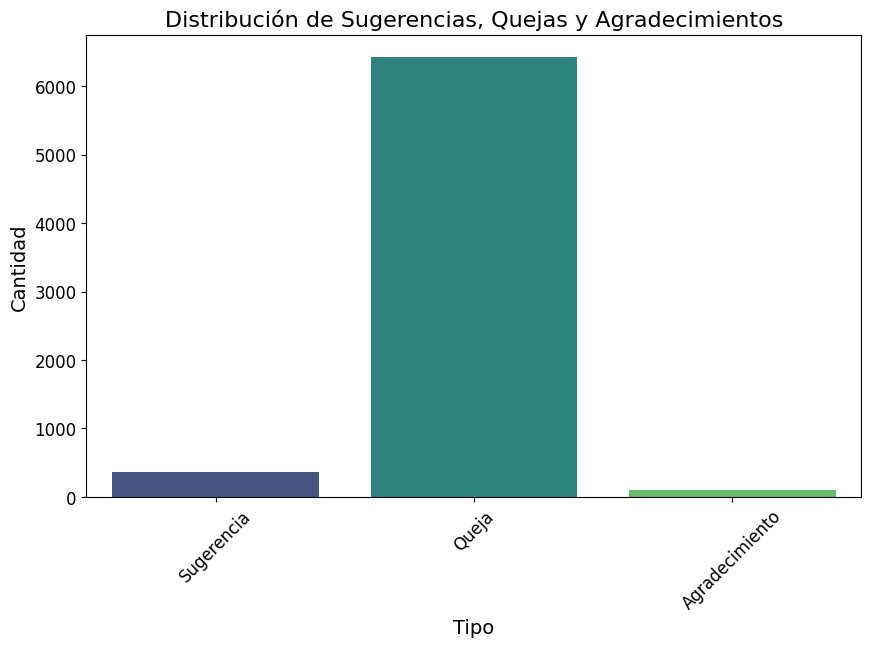

C:\Users\wilfr\AppData\Local\Temp\ipykernel_2428\3919837611.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_fecha_entrada.resample('M').size().plot()


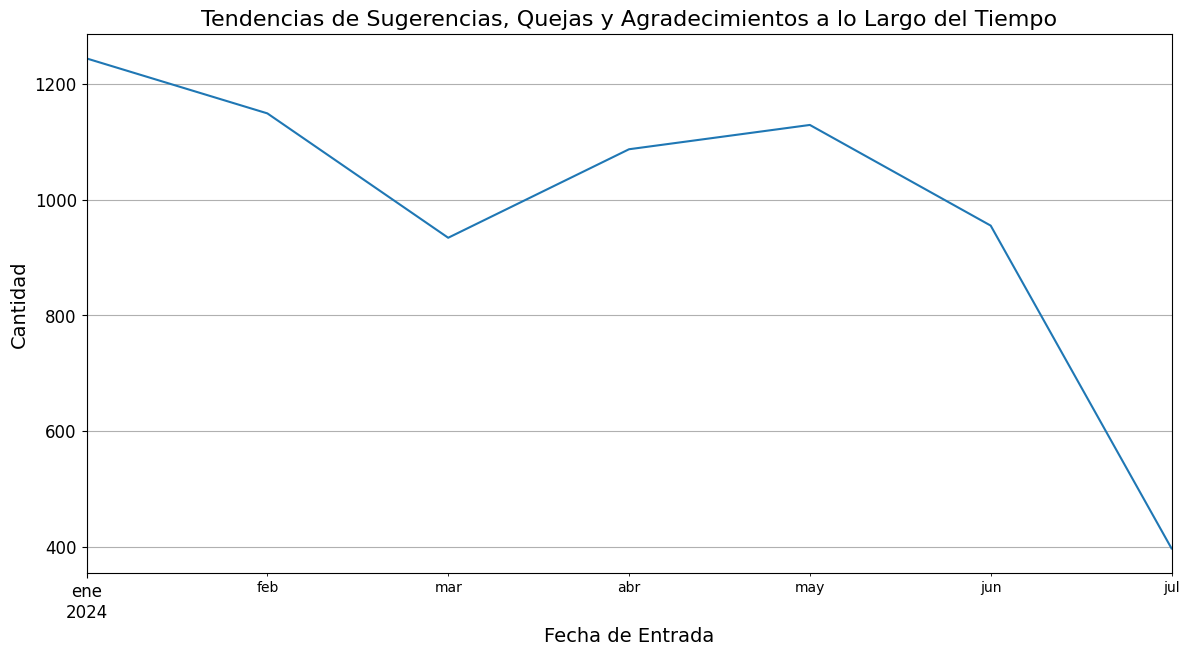

C:\Users\wilfr\AppData\Local\Temp\ipykernel_2428\3919837611.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_fecha_contestacion.resample('M').size().plot()


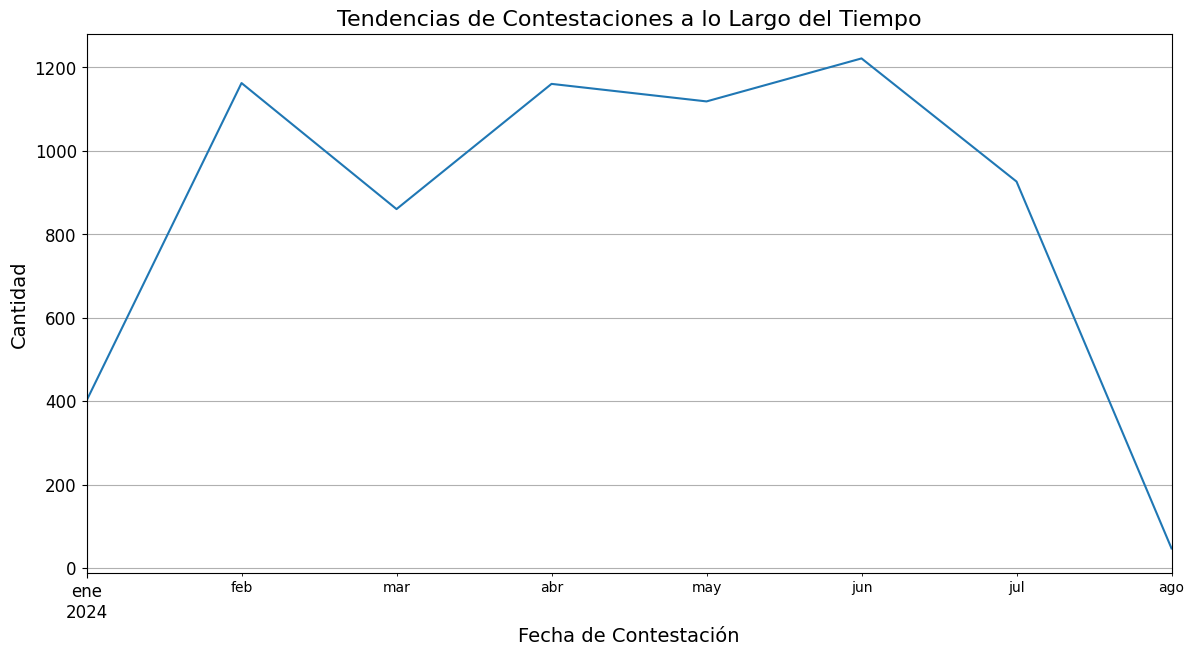

In [17]:
# Distribución de sugerencias, quejas y agradecimientos
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='tipo', palette="viridis")
plt.title('Distribución de Sugerencias, Quejas y Agradecimientos', fontsize=16)
plt.xlabel('Tipo', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# Tendencias a lo largo del tiempo utilizando fecha_entrada
if 'fecha_entrada' in df.columns:
    df_fecha_entrada = df.set_index('fecha_entrada')
    plt.figure(figsize=(14, 7))
    df_fecha_entrada.resample('M').size().plot()
    plt.title('Tendencias de Sugerencias, Quejas y Agradecimientos a lo Largo del Tiempo', fontsize=16)
    plt.xlabel('Fecha de Entrada', fontsize=14)
    plt.ylabel('Cantidad', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.show()

# Análisis de tendencias con fecha_contestacion
if 'fecha_contestacion' in df.columns:
    df_fecha_contestacion = df.set_index('fecha_contestacion')
    plt.figure(figsize=(14, 7))
    df_fecha_contestacion.resample('M').size().plot()
    plt.title('Tendencias de Contestaciones a lo Largo del Tiempo', fontsize=16)
    plt.xlabel('Fecha de Contestación', fontsize=14)
    plt.ylabel('Cantidad', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.show()

In [18]:
# Calcular la diferencia en días entre fecha_entrada y fecha_contestacion
df['tiempo_respuesta'] = (df['fecha_contestacion'] - df['fecha_entrada']).dt.days

# Mostrar las primeras filas para verificar el cálculo
print(df[['fecha_entrada', 'fecha_contestacion', 'tiempo_respuesta']].head())

# Calcular el promedio de tiempo de respuesta
promedio_tiempo_respuesta = df['tiempo_respuesta'].mean()

print(f"El promedio de tiempo de contestación es de {promedio_tiempo_respuesta:.2f} días.")


  fecha_entrada fecha_contestacion  tiempo_respuesta
0    2024-01-01         2024-01-26                25
1    2024-01-01         2024-02-02                32
2    2024-01-01         2024-05-14               134
4    2024-01-02         2024-01-17                15
5    2024-01-02         2024-01-26                24
El promedio de tiempo de contestación es de 21.07 días.


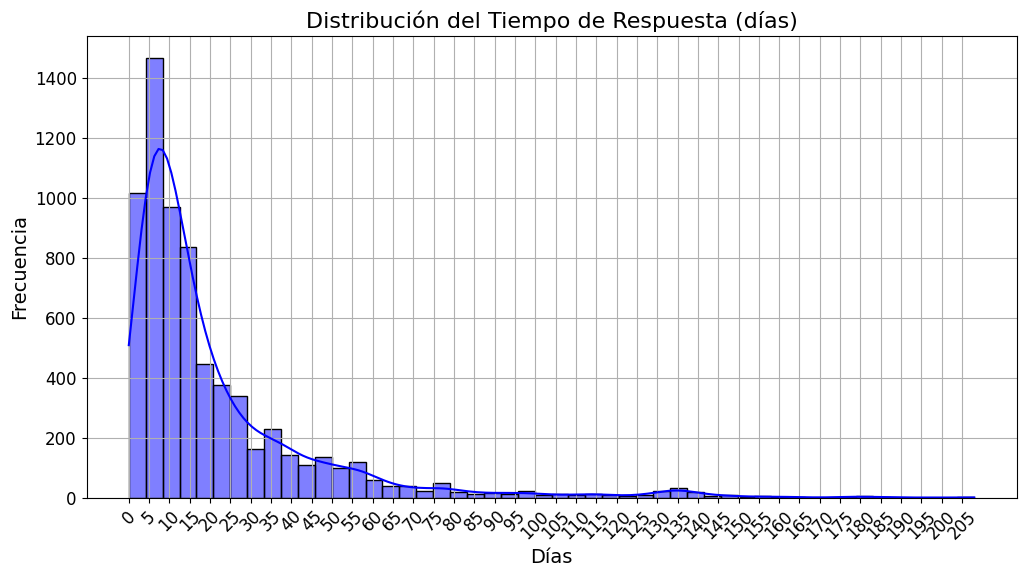

In [19]:
#Visualizacion de los tiempos de respuesta
plt.figure(figsize=(12, 6))
sns.histplot(df['tiempo_respuesta'], bins=50, kde=True, color='blue')
plt.title('Distribución del Tiempo de Respuesta (días)', fontsize=16)
plt.xlabel('Días', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
# Ajustar las etiquetas del eje X para que se vean mejor
plt.xticks(ticks=range(0, df['tiempo_respuesta'].max() + 1, 5), fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

In [20]:
# Filtrar las entradas con tiempo de respuesta mayor a 15 días
df_lentas = df[df['tiempo_respuesta'] > 15]

# Seleccionar las columnas de interés
df_lentas = df_lentas[['consejeria', 'tema', 'subtema', 'tiempo_respuesta']]

# Mostrar las primeras filas del DataFrame resultante
print(df_lentas.head())

                                          consejeria            tema  \
0           Consejería de Cultura, Turismo y Deporte         CULTURA   
1  Consejería de Vivienda, Transportes e Infraest...        VIVIENDA   
2  Consejería de Medio Ambiente, Agricultura e In...  MEDIO AMBIENTE   
5  Consejería de Vivienda, Transportes e Infraest...        VIVIENDA   
7  Consejería de Vivienda, Transportes e Infraest...     TRANSPORTES   

               subtema  tiempo_respuesta  
0          BIBLIOTECAS                25  
1  VIVIENDAS DEL IVIMA                32  
2      ENTORNO NATURAL               134  
5                OTROS                24  
7           CARRETERAS               149  


<Figure size 1400x800 with 0 Axes>

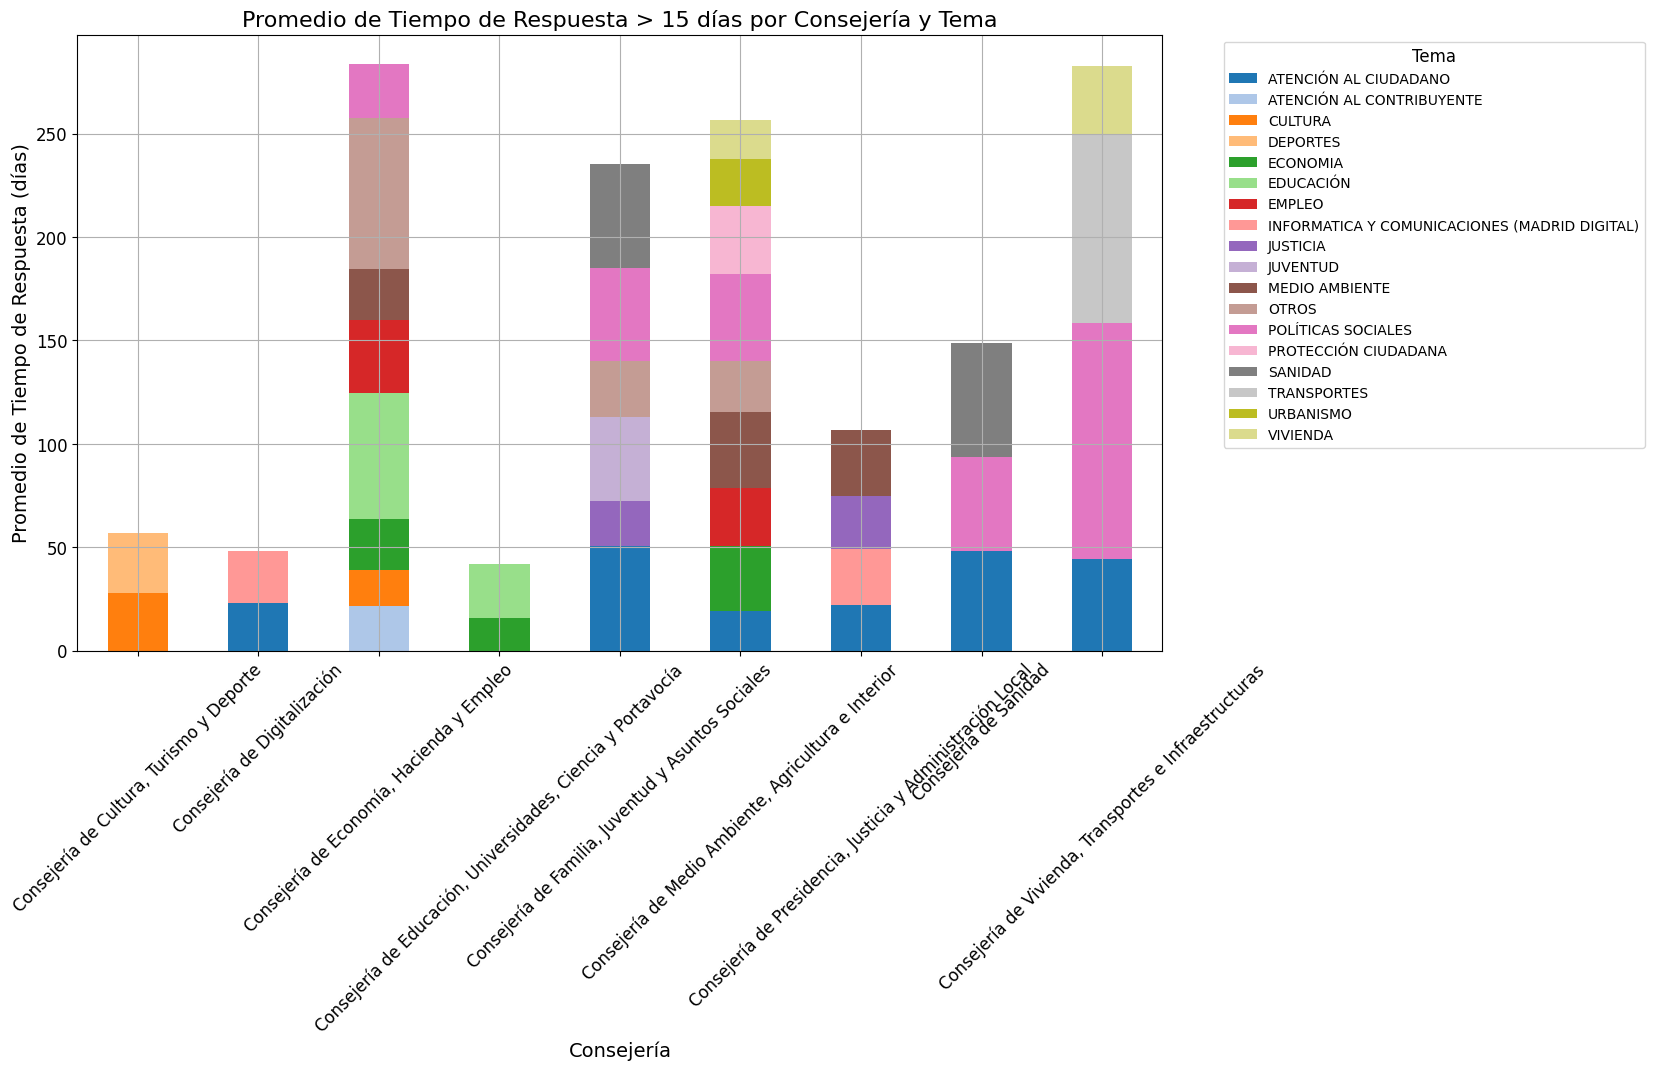

In [21]:
# Definir una paleta de colores con suficientes colores únicos
# Puedes elegir 'tab20', 'tab20b', 'tab20c' u otra paleta extendida
palette = sns.color_palette("tab20", n_colors=len(df_lentas['tema'].unique()))

# Crear el pivot table de nuevo para el gráfico
df_pivot = df_lentas.pivot_table(index='consejeria', columns='tema', values='tiempo_respuesta', aggfunc='mean')

plt.figure(figsize=(14, 8))

# Crear el gráfico de barras apiladas
df_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), color=palette)

plt.title('Promedio de Tiempo de Respuesta > 15 días por Consejería y Tema', fontsize=16)
plt.xlabel('Consejería', fontsize=14)
plt.ylabel('Promedio de Tiempo de Respuesta (días)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Tema', fontsize=10, title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

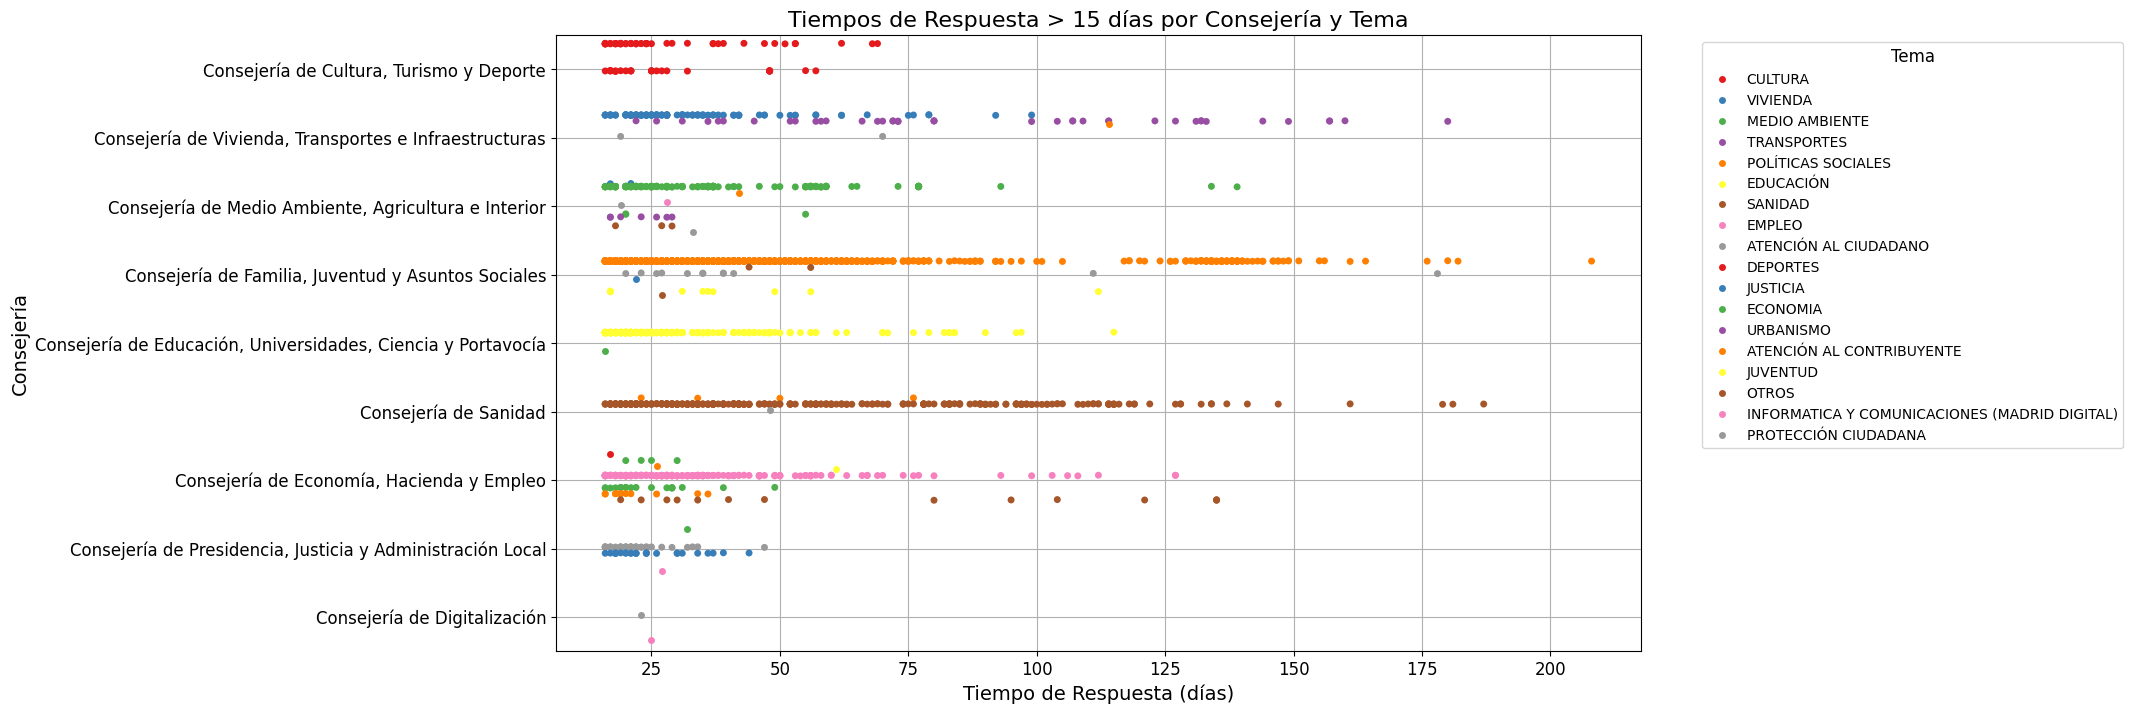

In [22]:
plt.figure(figsize=(14, 8))

# Crear un gráfico de puntos
sns.stripplot(data=df_lentas, x='tiempo_respuesta', y='consejeria', hue='tema', jitter=True, dodge=True, palette='Set1')

plt.title('Tiempos de Respuesta > 15 días por Consejería y Tema', fontsize=16)
plt.xlabel('Tiempo de Respuesta (días)', fontsize=14)
plt.ylabel('Consejería', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Tema', fontsize=10, title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [23]:
# Consejería con más datos
consejeria_counts = df['consejeria'].value_counts()
consejeria_mas_comun = consejeria_counts.idxmax()
consejeria_max_valor = consejeria_counts.max()
print(f"La consejería con más datos es '{consejeria_mas_comun}' con {consejeria_max_valor} registros.")

# Tema con más datos
tema_counts = df['tema'].value_counts()
tema_mas_comun = tema_counts.idxmax()
tema_max_valor = tema_counts.max()
print(f"El tema con más datos es '{tema_mas_comun}' con {tema_max_valor} registros.")

# Combinación de consejería y tema más común
combinacion_counts = df.groupby(['consejeria', 'tema']).size().reset_index(name='counts')
combinacion_mas_comun = combinacion_counts.loc[combinacion_counts['counts'].idxmax()]

consejeria_combinacion = combinacion_mas_comun['consejeria']
tema_combinacion = combinacion_mas_comun['tema']
count_combinacion = combinacion_mas_comun['counts']

print(f"La combinación de consejería y tema más común es '{consejeria_combinacion}' y '{tema_combinacion}' con {count_combinacion} registros.")


La consejería con más datos es 'Consejería de Familia, Juventud y Asuntos Sociales' con 2688 registros.
El tema con más datos es 'POLÍTICAS SOCIALES' con 2639 registros.
La combinación de consejería y tema más común es 'Consejería de Familia, Juventud y Asuntos Sociales' y 'POLÍTICAS SOCIALES' con 2629 registros.


### 4. Análisis avanzado


##### 1. Análisis de Correlación


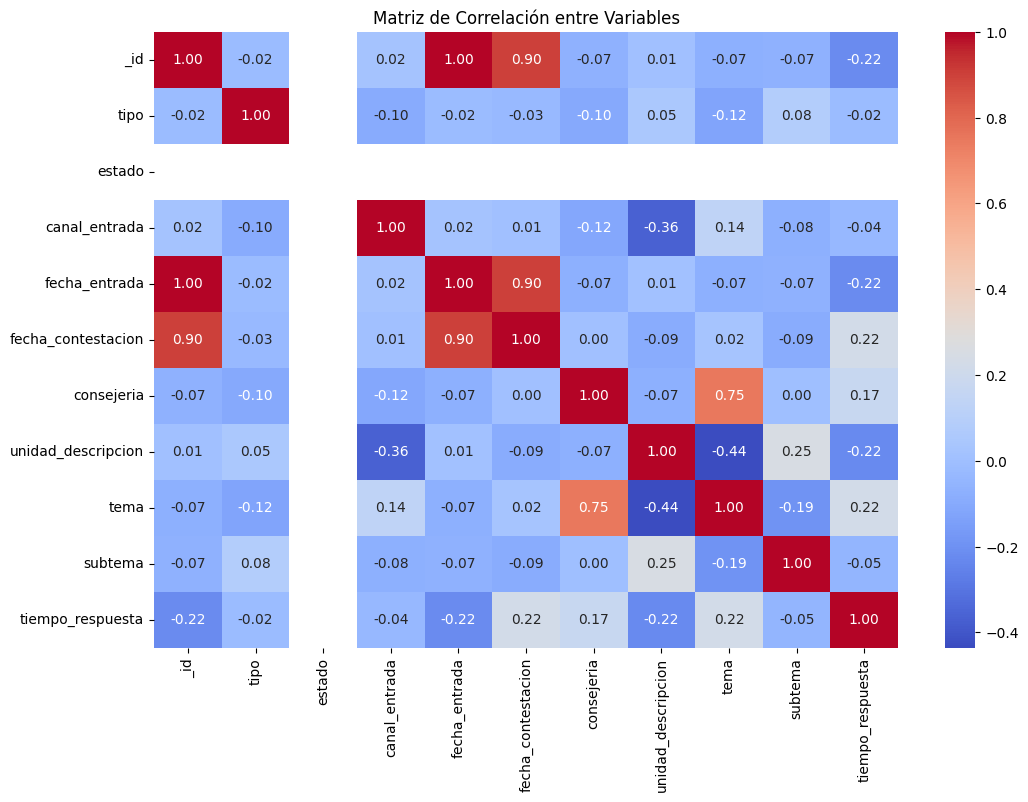

In [26]:

# Crear un objeto LabelEncoder
le = LabelEncoder()

# Aplicar el LabelEncoder a las columnas categóricas
df_encoded = df.copy()
categorical_cols = ['tipo', 'estado', 'canal_entrada', 'consejeria', 'unidad_descripcion', 'tema', 'subtema']
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df[col])

# Calcular la correlación de Pearson
correlation_matrix = df_encoded.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre Variables')
plt.show()

##### 2. Clustering (Agrupamiento) con K-means

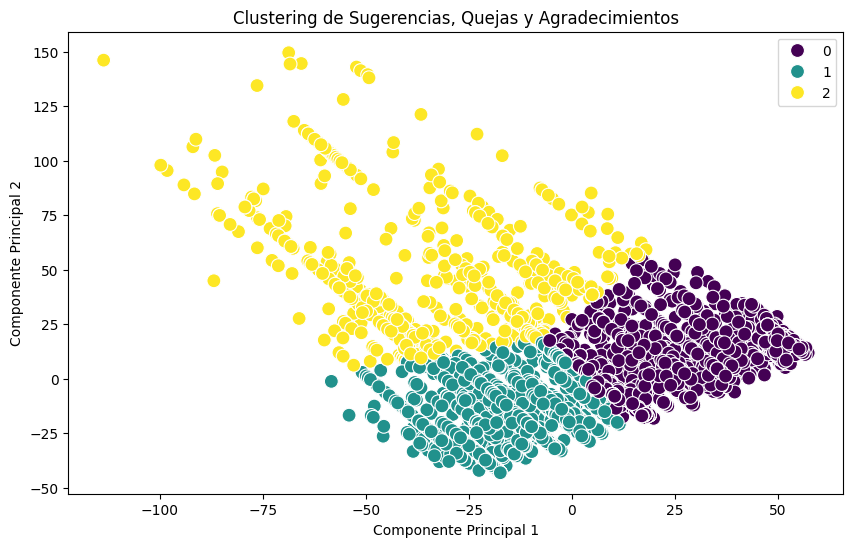

In [39]:
# Seleccionar características para el clustering (usando variables numéricas transformadas)
features = df_encoded[['tipo', 'estado', 'canal_entrada', 'consejeria', 'unidad_descripcion', 'tema', 'subtema', 'tiempo_respuesta']]

# Reducir la dimensionalidad con PCA para visualizar
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# Realizar K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_pca)

# Añadir la columna de clusters al DataFrame original
df['cluster'] = clusters

# Visualizar los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=clusters, palette='viridis', s=100)
plt.title('Clustering de Sugerencias, Quejas y Agradecimientos')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

plt.show()


In [37]:
# Obtener las cargas de los componentes
pca_cargas = pd.DataFrame(pca.components_, columns=features.columns, index=['Componente Principal 1', 'Componente Principal 2'])

# Mostrar las cargas para CP1 y CP2
print(pca_cargas)


                            tipo  consejeria      tema   subtema  \
Componente Principal 1  0.000801   -0.005778 -0.046675  0.885965   
Componente Principal 2  0.000218    0.012012  0.020191  0.462642   

                        tiempo_respuesta  
Componente Principal 1         -0.461361  
Componente Principal 2          0.886234  


##### 3. Análisis de Componentes Principales (PCA)


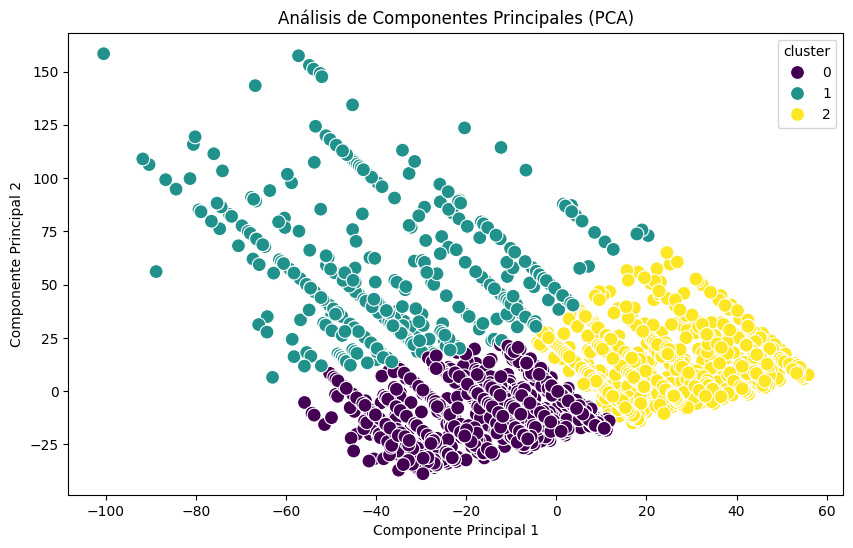

In [38]:
# PCA para reducción de dimensionalidad
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Añadir los resultados de PCA al DataFrame
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Visualizar los componentes principales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=df, palette='viridis', s=100)
plt.title('Análisis de Componentes Principales (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()


##### 4. Análisis de Varianza (ANOVA)


In [41]:
# Realizar ANOVA entre 'consejeria' y 'tiempo_respuesta'
model = ols('tiempo_respuesta ~ C(consejeria)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)


                     sum_sq      df          F         PR(>F)
C(consejeria)  4.176796e+05     8.0  93.966183  7.773864e-149
Residual       3.826033e+06  6886.0        NaN            NaN


##### 5. Regresión Lineal Simple


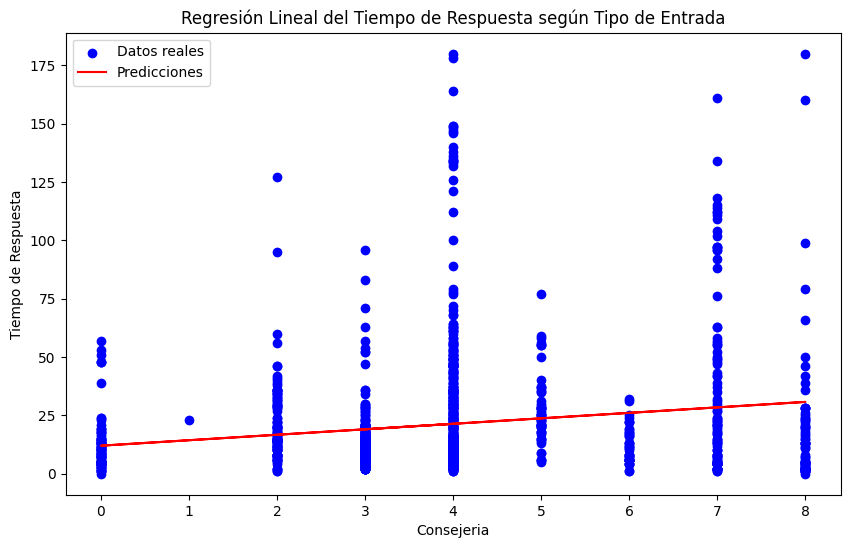

In [48]:
# Seleccionar variables para la regresión
X = df_encoded[['consejeria']]
y = df['tiempo_respuesta']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Datos reales')
plt.plot(X_test, y_pred, color='red', label='Predicciones')
plt.title('Regresión Lineal del Tiempo de Respuesta según Tipo de Entrada')
plt.xlabel('Consejeria')
plt.ylabel('Tiempo de Respuesta')
plt.legend()
plt.show()


In [49]:
# Extraer y mostrar las consejerías únicas
consejerias_unicas = df['consejeria'].unique()

# Imprimir las consejerías como texto
print("Consejerías disponibles en el dataset:")
for consejeria in consejerias_unicas:
    print(consejeria)


Consejerías disponibles en el dataset:
Consejería de Cultura, Turismo y Deporte
Consejería de Vivienda, Transportes e Infraestructuras
Consejería de Medio Ambiente, Agricultura e Interior
Consejería de Educación, Universidades, Ciencia y Portavocía
Consejería de Familia, Juventud y Asuntos Sociales
Consejería de Presidencia, Justicia y Administración Local
Consejería de Sanidad
Consejería de Economía, Hacienda y Empleo
Consejería de Digitalización
